# Inverse distance weighting example

Spatial interpolation snippet with IWD technique (implementation of [@paulbrodersen](https://github.com/paulbrodersen/inverse_distance_weighting)). 

In [1]:
import pandas as pd
import numpy as np 

import geopandas as gpd
import shapely
import fiona
import folium

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

Dataset loading and parsing

In [2]:
LSOA_SHAPE_FOLDER = '/home/adelsondias/Repos/newcastle/air-quality/shape/Middle_Layer_Super_Output_Areas_December_2011_Full_Extent_Boundaries_in_England_and_Wales/'
DATA_FOLDER = '/home/adelsondias/Repos/newcastle/air-quality/data_7days/'

lsoa = gpd.read_file(LSOA_SHAPE_FOLDER+'Middle_Layer_Super_Output_Areas_December_2011_Full_Extent_Boundaries_in_England_and_Wales.shp')
lsoa = lsoa[lsoa['msoa11nm'].str.contains('Newcastle upon Tyne')]
lsoa = lsoa.to_crs(fiona.crs.from_epsg(4326))
lsoa.crs = {'init': 'epsg:4326', 'no_defs': True}

metadata = pd.read_csv(DATA_FOLDER+'sensors.csv')

# spatial parsing - geometry column
metadata = gpd.GeoDataFrame(metadata[['name','type','active','lon','lat']],
                        geometry=[shapely.geometry.Point(xy) for xy in zip(metadata['lon'], metadata['lat'])], 
                        crs={'init': 'epsg:4326'}).to_crs(fiona.crs.from_epsg(4326))

metadata = gpd.sjoin(metadata, lsoa, how='inner' ,op='intersects')[['name','type','active','lon','lat','geometry']]
metadata = metadata.set_index('name')

sensors = pd.read_csv(DATA_FOLDER+'data.csv')
sensors['Timestamp'] = pd.to_datetime(sensors['Timestamp'])
sensors = sensors.set_index(['Variable','Sensor Name','Timestamp'])

# resampling by freq
freq='D'
level_values = sensors.index.get_level_values
sensors = (sensors.groupby([level_values(i) for i in [0,1]]
                   +[pd.Grouper(freq=freq, level=-1)]).median())

# filtering by Newcastle's region
m = metadata.index.values
s = sensors.reset_index()
s = s.loc[s['Sensor Name'].isin(m)]
sensors = s.set_index(['Variable','Sensor Name','Timestamp'])

variables = ['CO', 'Humidity', 'Journey Time', 'NO2', 'O3', 
             'PM10', 'Particle Count', 'Sound', 'Temperature', 
             'Wind Direction', 'Wind Speed']

sensors = sensors.loc[variables]
metadata = metadata.loc[sensors.index.get_level_values(1).unique()]

In [3]:
idx = pd.IndexSlice

a = sensors.loc[idx['NO2',:,'2018-07-06'],:].reset_index((0,2)).join(metadata)[['Value','lon','lat']]

X1 = a.loc[a['lon']<-1.60][['lon','lat']].values
z1 = a.loc[a['lon']<-1.60][['Value']].values.reshape(-1,)

In [4]:
a.head()

,Value,lon,lat
Sensor Name,,,
aq_mesh1756150,35.604662,-1.617166,54.974211
aq_mesh1757150,34.312820,-1.617310,54.972260
aq_mesh1758150,30.726531,-1.612730,54.975750
aq_mesh1759150,43.488536,-1.613355,54.977854
aq_mesh1760150,46.665923,-1.610690,54.972230


## Implementation

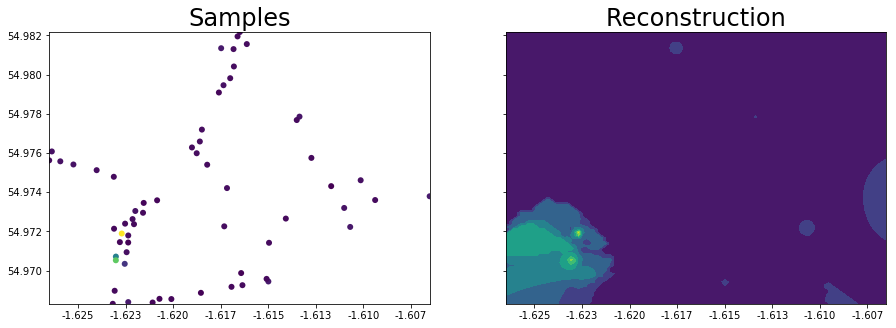

In [5]:
import idw

# 'train'
idw_tree = idw.tree(X1, z1)
# 'test'
xspacing = np.linspace(X1[:,0].min(), X1[:,0].max(), 100)
yspacing = np.linspace(X1[:,1].min(), X1[:,1].max(), 100)
X2 = np.meshgrid(xspacing, yspacing)
grid_shape = X2[0].shape
X2 = np.reshape(X2, (2, -1)).T

z2 = idw_tree(X2)

# plot
fig, (ax1, ax2) = plt.subplots(1,2, sharex=True, sharey=True, figsize=(15,5))
ax1.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.3f'))
ax1.scatter(X1[:,0], X1[:,1], c=z1, linewidths=0)
ax1.set_title('Samples',fontsize=24)
ax2.contourf(xspacing, yspacing, z2.reshape(grid_shape))
ax2.set_title('Reconstruction',fontsize=24)
plt.xlim(X1[:,0].min(), X1[:,0].max())
plt.ylim(X1[:,1].min(), X1[:,1].max())
plt.show()

## Evaluation

Calculating R2 score with "leave-one-out" technique

In [6]:
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

scores = []
kf = KFold(n_splits=5)
for train_index, test_index in kf.split(X1):
    X_train, X_test = X1[train_index], X1[test_index]
    z_train, z_test = z1[train_index], z1[test_index]
    
    # train
    idw_tree = idw.tree(X_train, z_train)
    
    # test
    z_pred = idw_tree(X_test)
    scores.append(r2_score(z_pred,z_test))
scores

[-30.884971519604342,
 -3.7234697043598866,
 -6.67071277284843,
 -7.772279527096739,
 -1.0300139358193392]